# CIFAR-10 Dataset Visualization & Pretrained ResNet18 Baseline

This notebook:
- Visualizes CIFAR-10 dataset splits (train/val/test)
- Evaluates pretrained ResNet18 (ImageNet) on CIFAR-10 as baseline
- Verifies dataset quality before finetuning

## Setup Environment

In [1]:
LOCAL = True

# if run locally:
if LOCAL:
    ROOT_DIR = "/Users/Yang/Desktop/research-model-merge/playground/merge_soup-resnet18-cifar10"
    DATA_DIR = "/Users/Yang/Desktop/research-model-merge/datasets"
    PROJECT_ROOT = "/Users/Yang/Desktop/research-model-merge"
else:
    # on Colab
    ROOT_DIR = "/content"
    DATA_DIR = "/content/datasets"
    PROJECT_ROOT = "/content"
    from google.colab import drive
    drive.mount('/content/drive')
    DRIVE_DIR = "drive/MyDrive/research-model_merge"

In [2]:
import os
import sys
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision.models import resnet18, ResNet18_Weights

# Add project root to path
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

# Add utils to path
if ROOT_DIR not in sys.path:
    sys.path.insert(0, ROOT_DIR)

from datasets.cifar10 import CIFAR10
from utils import eval_model_on_dataset, show_split_samples, show_split_samples_with_predictions

In [3]:
# Check GPU availability and system info
import subprocess

print("🔍 System Information:")
print(f"Python version: {subprocess.check_output(['python', '--version']).decode().strip()}")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"GPU device: {torch.cuda.get_device_name(0)}")
    print(f"GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
    print(f"CUDA version: {torch.version.cuda}")
    DEVICE = torch.device("cuda")
else:
    print("⚠️ No GPU available! Using CPU.")
    DEVICE = torch.device("cpu")

🔍 System Information:
Python version: Python 3.11.5
PyTorch version: 2.8.0
CUDA available: False
⚠️ No GPU available! Using CPU.


## CIFAR-10 Dataset - View

**Note**: This uses persistent indices from `datasets/cifar10_train_val_indices.npy`
- Training: 98% of original training set (49,000 images)  
- Validation: 2% of original training set (1,000 images)  
- Test: Official CIFAR-10 test set (10,000 images)

⚠️ **Persistent indices ensure consistent splits across all experiments!**

In [4]:
# Check if persistent indices exist
INDICES_FILE = os.path.join(DATA_DIR, 'cifar10_train_val_indices.npy')

print("🔍 Checking for persistent indices...")

if os.path.exists(INDICES_FILE):
    print(f"✅ Found persistent indices: {INDICES_FILE}")
else:
    print(f"❌ Persistent indices not found: {INDICES_FILE}")
    print("   Run: cd datasets && python generate_train_val_indices.py cifar10")

🔍 Checking for persistent indices...
✅ Found persistent indices: /Users/Yang/Desktop/research-model-merge/datasets/cifar10_train_val_indices.npy


In [ ]:
print("Creating CIFAR-10 dataset...")

dataset = CIFAR10(
    data_location=DATA_DIR,
    batch_size=8,  # Small batch for visualization
    num_workers=2
)

print(f"✅ Dataset created:")
print(f"   Train split: {len(dataset.train_sampler)} samples")
print(f"   Val split: {len(dataset.val_sampler)} samples")
print(f"   Test split: {len(dataset.test_dataset)} samples")
print(f"   Classnames: {dataset.classnames}")

Creating CIFAR-10 dataset...


In [ ]:
import numpy as np
import pandas as pd

def check_class_balance(dataset, split_name):
    """Check class distribution for a given split"""
    
    # Get the appropriate dataset and indices
    if split_name == "train":
        indices = list(dataset.train_sampler.indices)
        full_dataset = dataset.train_dataset
    elif split_name == "validation":
        indices = list(dataset.val_sampler.indices)
        full_dataset = dataset.val_dataset
    elif split_name == "test":
        indices = list(range(len(dataset.test_dataset)))
        full_dataset = dataset.test_dataset
    else:
        raise ValueError(f"Unknown split: {split_name}")
    
    # Count samples per class
    class_counts = [0] * 10
    for idx in indices:
        _, label = full_dataset[idx]
        class_counts[label] += 1
    
    # Create summary
    print(f"\n{'='*60}")
    print(f"{split_name.upper()} Split - Class Distribution")
    print(f"{'='*60}")
    print(f"Total samples: {len(indices)}")
    print(f"\nPer-class breakdown:")
    
    data = []
    for i, count in enumerate(class_counts):
        class_name = dataset.classnames[i]
        percentage = 100 * count / len(indices)
        data.append({
            'Class': i,
            'Name': class_name,
            'Count': count,
            'Percentage': f"{percentage:.2f}%"
        })
        print(f"  {i}: {class_name:12s} - {count:5d} samples ({percentage:.2f}%)")
    
    # Check balance
    min_count = min(class_counts)
    max_count = max(class_counts)
    balance_ratio = min_count / max_count if max_count > 0 else 0
    
    print(f"\nBalance metrics:")
    print(f"  Min samples: {min_count}")
    print(f"  Max samples: {max_count}")
    print(f"  Balance ratio: {balance_ratio:.3f} (1.0 = perfect balance)")
    
    if balance_ratio >= 0.95:
        print(f"  ✅ Excellent balance!")
    elif balance_ratio >= 0.90:
        print(f"  ✅ Good balance")
    else:
        print(f"  ⚠️  Imbalanced (ratio < 0.90)")
    
    return data

# Check balance for all splits
train_data = check_class_balance(dataset, "train")
val_data = check_class_balance(dataset, "validation")
test_data = check_class_balance(dataset, "test")

ModuleNotFoundError: No module named 'pandas'

### Check Class Balance for Each Split

Check that each split has balanced class distribution

### Visualize Training Split

/Users/Yang/Desktop/research-model-merge/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Fetching 8 samples from train split


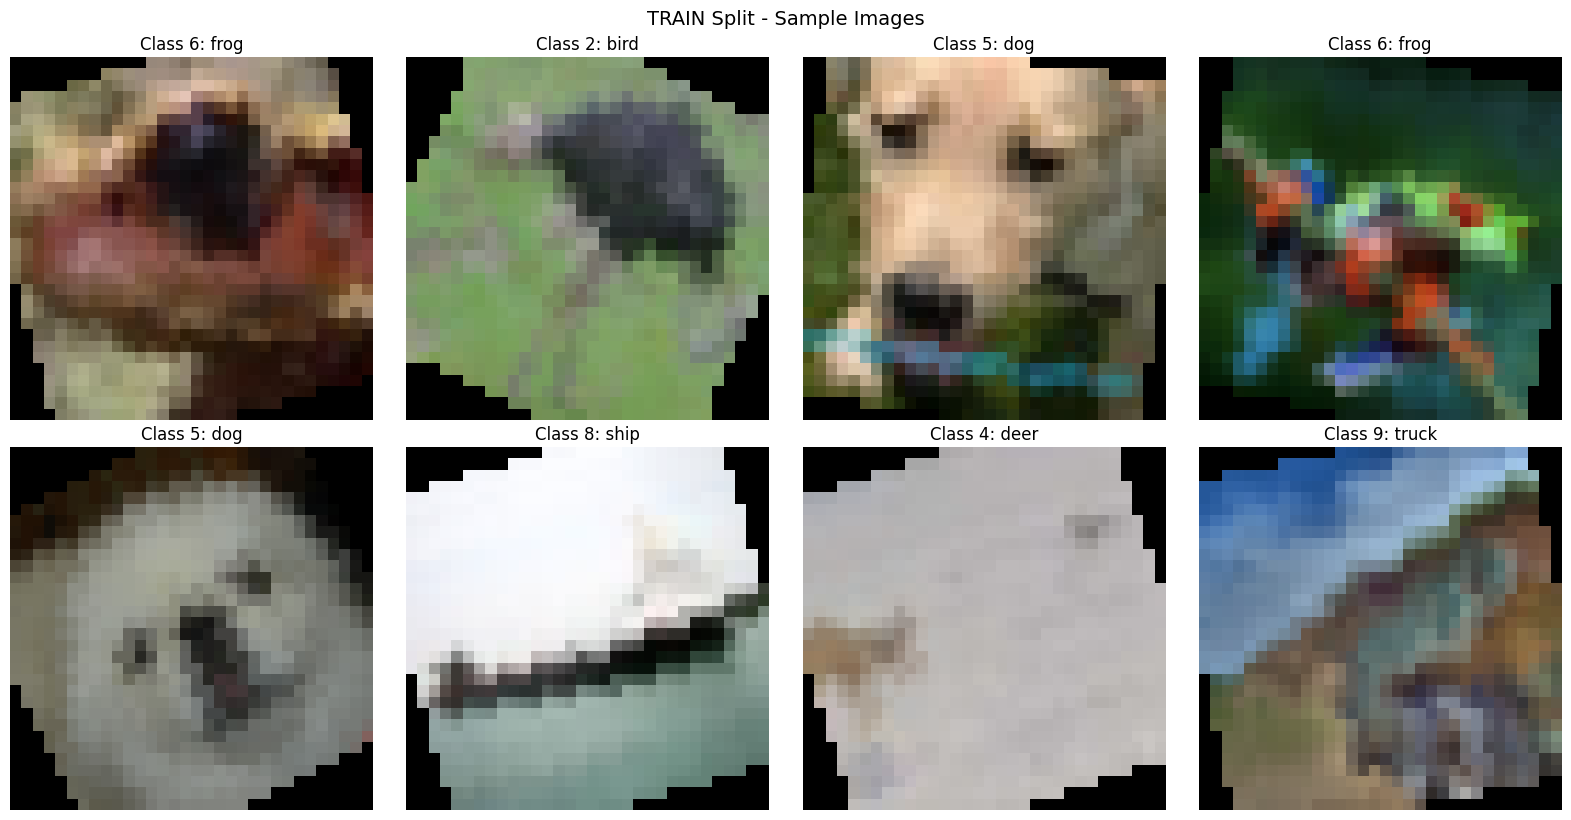

In [ ]:
show_split_samples(dataset, "train", batch_index=0)

### Visualize Validation Split

Fetching 8 samples from validation split


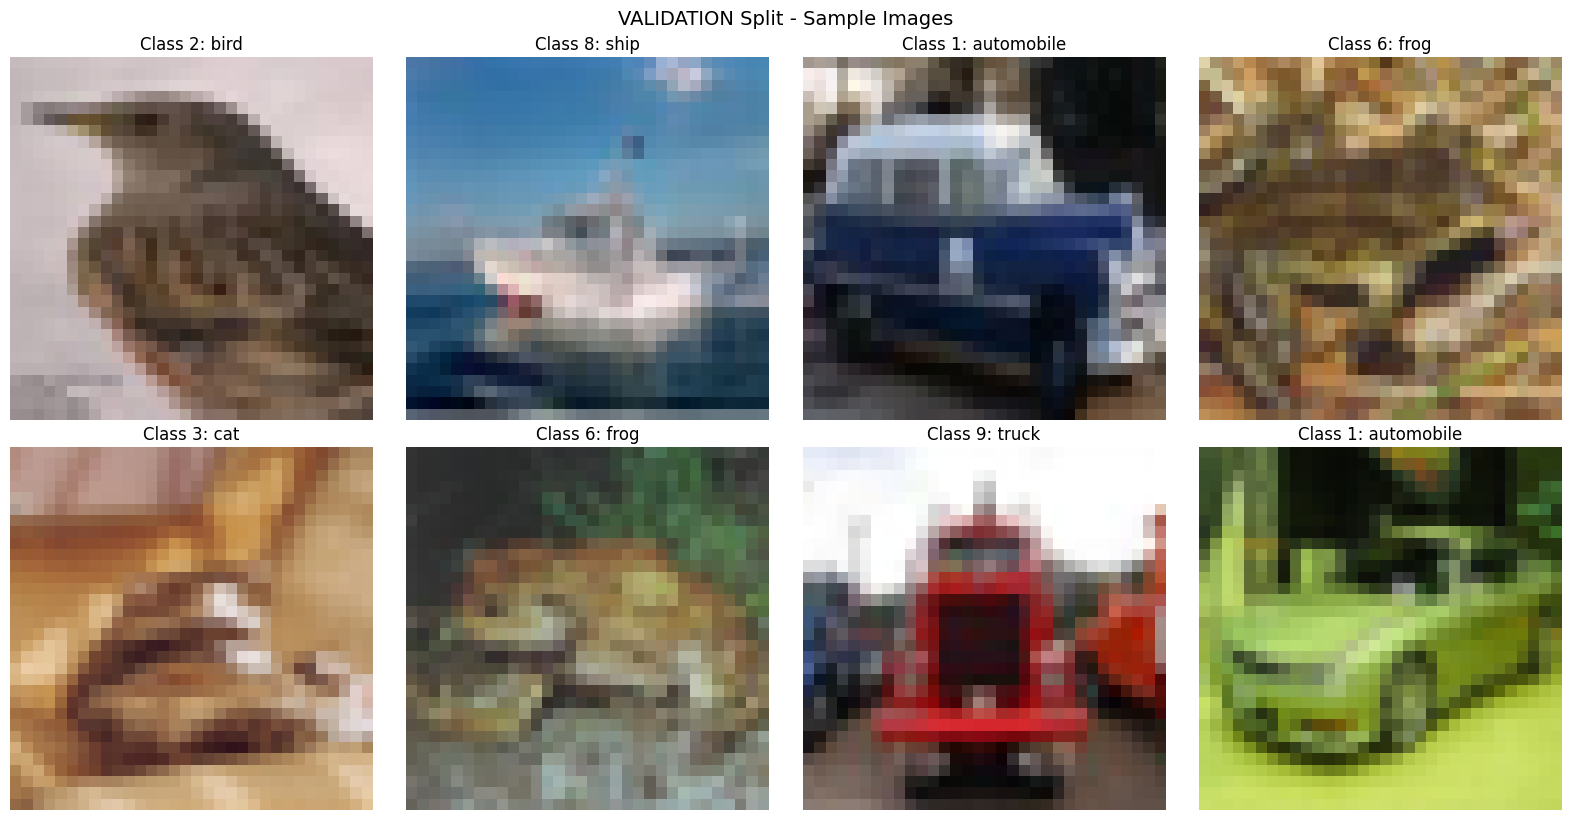

In [ ]:
show_split_samples(dataset, "validation", batch_index=0)

### Visualize Test Split

Fetching 8 samples from test split


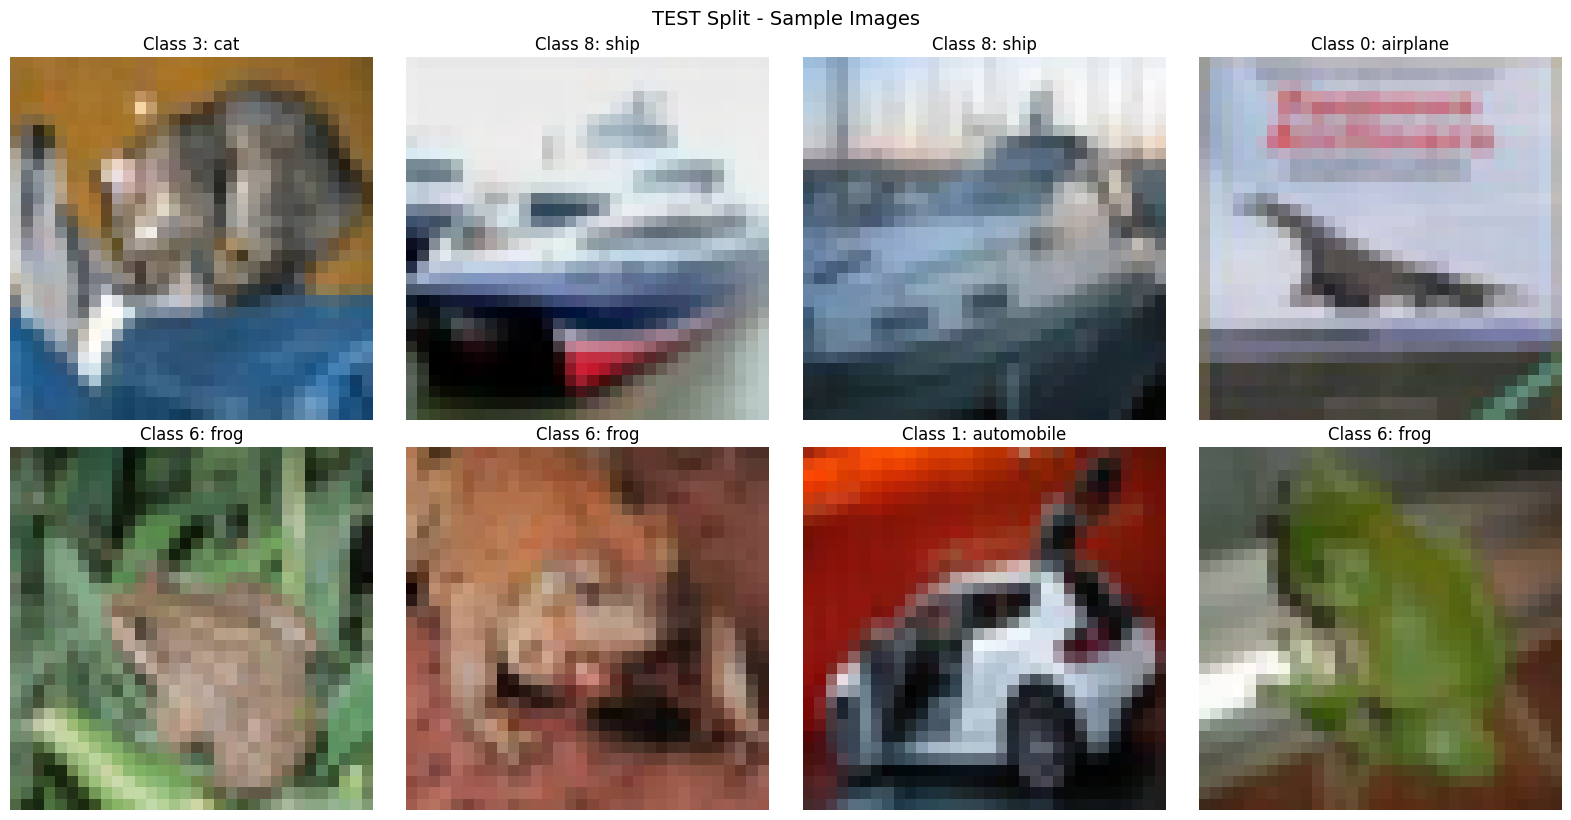

In [ ]:
show_split_samples(dataset, "test", batch_index=0)

## Pretrained ResNet18 Baseline Evaluation

Evaluate pretrained ResNet18 (ImageNet) on CIFAR-10 **without finetuning**.

This establishes a baseline. Since the FC layer is randomly initialized and CIFAR-10 images are smaller (32x32 vs 224x224), we expect low accuracy (~10-20%).

**Model Modifications for CIFAR-10:**
- First conv layer: 7x7 kernel, stride 2 → 3x3 kernel, stride 1
- Remove maxpool layer (too aggressive for 32x32 images)
- Final FC layer: 1000 classes → 10 classes (random initialization)

In [ ]:
print("Loading pretrained ResNet18 (ImageNet weights)...")

# Load pretrained ResNet18
model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

# Modify for CIFAR-10
model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
model.maxpool = nn.Identity()

# Replace final FC layer (random init)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 10)

model = model.to(DEVICE)
model.eval()

print("✅ Model loaded and modified for CIFAR-10")
print(f"   Model on device: {next(model.parameters()).device}")

Loading pretrained ResNet18 (ImageNet weights)...
✅ Model loaded and modified for CIFAR-10
   Model on device: cpu


In [ ]:
print("\n📊 Evaluating pretrained ResNet18 on CIFAR-10 test set...\n")

test_accuracy = eval_model_on_dataset(model, dataset.test_loader)

print(f"\n🎯 Pretrained ResNet18 Baseline (no finetuning):")
print(f"   Test Accuracy: {100*test_accuracy:.2f}%")
print(f"\n   Note: Low accuracy is expected since:")
print(f"   - FC layer is randomly initialized (not trained on CIFAR-10)")
print(f"   - CIFAR-10 classes differ from ImageNet classes")
print(f"   - This is the baseline before finetuning")


📊 Evaluating pretrained ResNet18 on CIFAR-10 test set...

[0% 0/1250]	Acc: 0.00	Data (t) 2.385	Batch (t) 2.435
[2% 20/1250]	Acc: 8.33	Data (t) 0.000	Batch (t) 0.023
[3% 40/1250]	Acc: 7.93	Data (t) 0.000	Batch (t) 0.023
[5% 60/1250]	Acc: 8.40	Data (t) 0.000	Batch (t) 0.022
[6% 80/1250]	Acc: 8.02	Data (t) 0.000	Batch (t) 0.023
[8% 100/1250]	Acc: 8.66	Data (t) 0.000	Batch (t) 0.023
[10% 120/1250]	Acc: 8.78	Data (t) 0.000	Batch (t) 0.024
[11% 140/1250]	Acc: 8.60	Data (t) 0.000	Batch (t) 0.023
[13% 160/1250]	Acc: 8.93	Data (t) 0.000	Batch (t) 0.022
[14% 180/1250]	Acc: 8.56	Data (t) 0.000	Batch (t) 0.023
[16% 200/1250]	Acc: 8.77	Data (t) 0.000	Batch (t) 0.023
[18% 220/1250]	Acc: 8.77	Data (t) 0.000	Batch (t) 0.022
[19% 240/1250]	Acc: 8.66	Data (t) 0.000	Batch (t) 0.023
[21% 260/1250]	Acc: 8.86	Data (t) 0.000	Batch (t) 0.024
[22% 280/1250]	Acc: 9.07	Data (t) 0.000	Batch (t) 0.024
[24% 300/1250]	Acc: 9.05	Data (t) 0.000	Batch (t) 0.028
[26% 320/1250]	Acc: 9.35	Data (t) 0.000	Batch (t) 0.024
[

### Visualize Predictions on Test Set

Fetching 8 samples from test split
Predictions: [2 2 2 1 2 2 2 2]


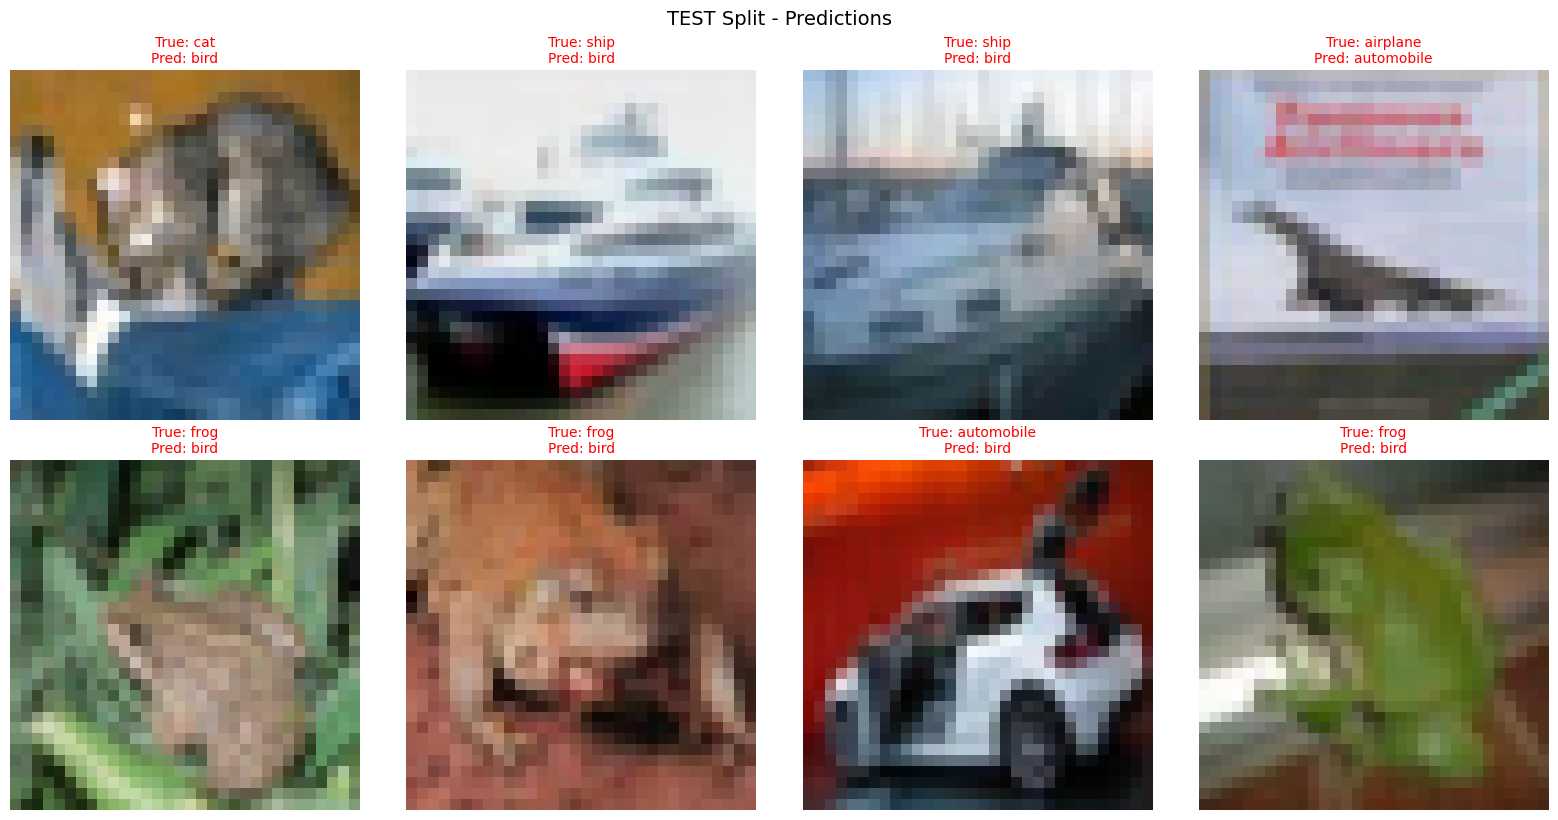

In [ ]:
show_split_samples_with_predictions(model, dataset, "test", batch_index=0)

Fetching 8 samples from test split
Predictions: [2 2 2 2 2 2 2 2]


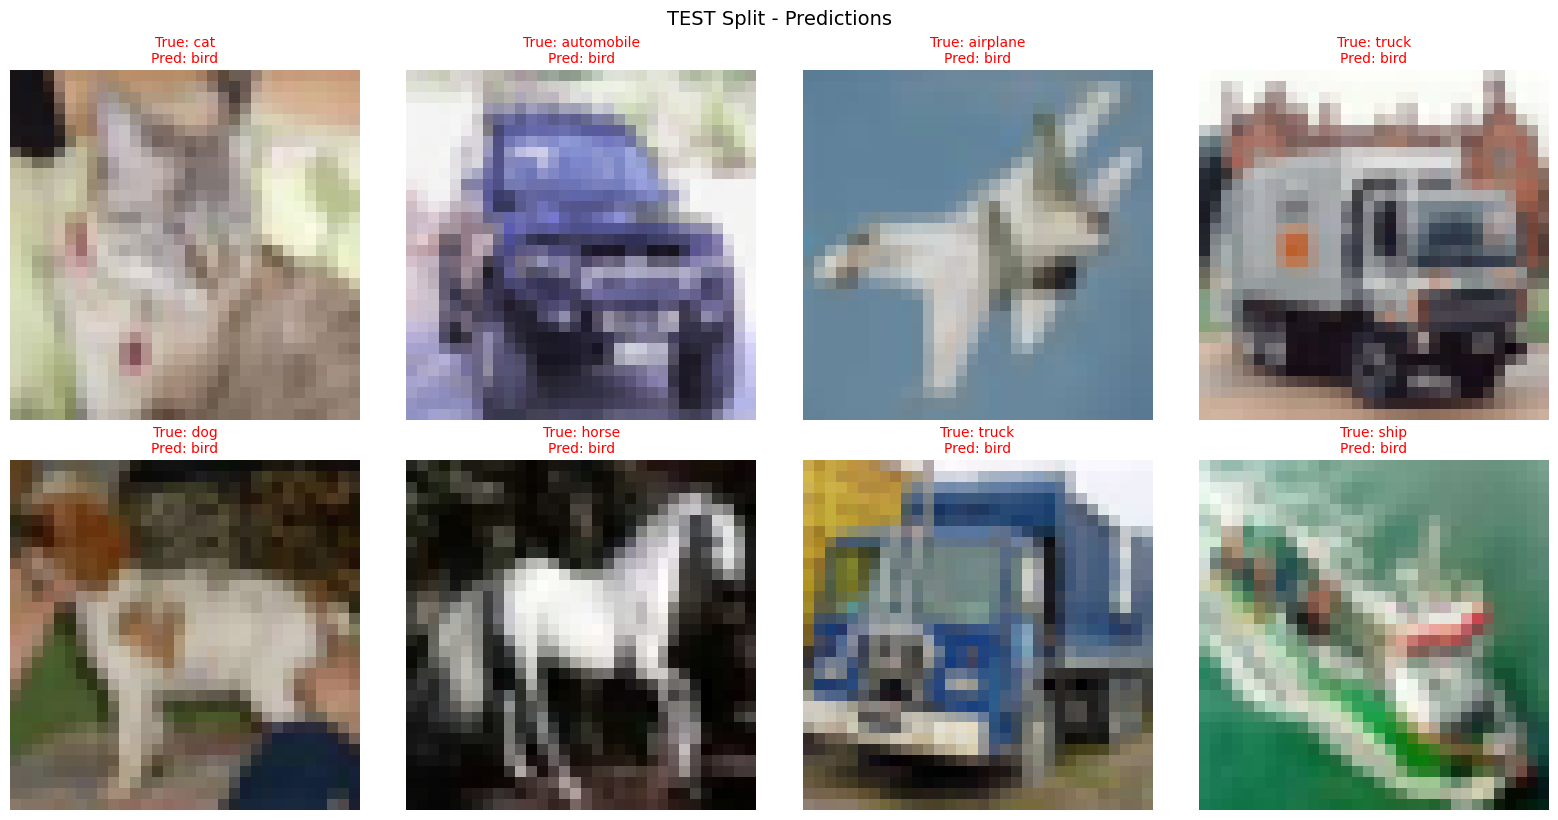

In [ ]:
show_split_samples_with_predictions(model, dataset, "test", batch_index=1)